# <span style="color:darkgreen">DATSCIW261 ASSIGNMENT 5</span>
#### MIDS UC Berkeley, Machine Learning at Scale

<b>AUTHOR</b> : Rajesh Thallam <br>
<b>EMAIL</b>  : rajesh.thallam@ischool.berkeley.edu <br>
<b>WEEK</b>   : 5 <br>
<b>DATE</b>   : 06-Oct-15

***

<h2><span style="color:dodgerblue;font:12px">HW5.0</span></h2> 

<span style="color:CornflowerBlue "><b>a. What is a data warehouse?<b></span><br>

A data warehouse is a database that designed for query and analysis rather than for transaction processing. It usually contains historical data derived from transaction data and other disparate data sources. It separates analysis workload from transaction workload and enables to consolidate data from several sources. For example, in my organization all healthcare claims from different claim adjudication systems are maintained in single data repository called Claims Data Warehouse

<span style="color:CornflowerBlue "><b>b. What is a Star schema? When is it used?<b></span><br>

- The star schema is the simplest data warehouse schema with dimensions radiating from a fact like a star. The center of the star consists of one or more fact tables and the points of the star are the dimension tables. In the aforementioned data warehouse, fact table is claim information and dimension is membership/patient information.

- It is used as a basic implementation of an OLAP cube. If the fact table contains a 1 to many relationship to each of the dimensions in the data warehouse schema then it is appropriate to use a star schema.

***

<h2><span style="color:dodgerblue;font:12px">HW5.1</span></h2> 

<span style="color:CornflowerBlue "><b>a. In the database world What is 3NF? Does machine learning use data in 3NF? If so why?  <b></span><br>

- Third normal form (3NF) is the process of normalizing a database which states that only foreign key columns should be used to reference another table, and no other columns from the parent table should exist in the referenced table. It is used to avoid data redundancy and ensure referential integrity by ensuring that the entity is in second normal form.

- ML requires data to be in denormalized format i.e. in a single row format. If the data set is in 3NF, it should be denormalized into 2NF.


<span style="color:CornflowerBlue "><b>b. In what form does ML consume data? <b></span><br>

- ML require data to be in a tabular format with each row representing a full transaction and each column as feature set. 

- In a typical data warehouse, data is stored in third normal form in separate tables. For example. one entity for customer information, another for transactions and another for account master. For ML algorithms, this data must be denormalized by joining all the tables into a single tabular format i.e. 2NF.

<span style="color:CornflowerBlue "><b>c. Why would one use log files that are denormalized? <b></span><br>

- Denormalized log files will have all required data for an event in single row allowing for quicker data processing.

***

<span style="color:CornflowerBlue; font-size:120%;"><b>Preparation for HW5_*<b></span>

<span style="color:CornflowerBlue; font-size: 120%;"><b>MRJob Configuration<b></span>

In [75]:
!cat /home/rt/.mrjob.conf | awk -F":" '{if ( $1 ~ /key/ ) { print $1": XXXX"} else { print $0} }'

runners:
    emr:
        aws_access_key_id: XXXX
        aws_secret_access_key: XXXX
        ec2_instance_type: m1.medium
        aws_region: us-east-1
        ec2_master_instance_type: m1.medium
        num_ec2_instances: 8
        enable_emr_debugging: true


***

<h2><span style="color:dodgerblue;font:12px">HW5.2</span></h2> <br>
<span style="color:firebrick">Using MRJob, implement a hashside join (memory-backed map-side) for left, right and inner joins. Run your code on the  data used in HW 4.4: (Recall HW 4.4: Find the most frequent visitor of each page using mrjob and the output of 4.2  (i.e., transfromed log file). In this output please include the webpage URL, webpageID and Visitor ID.). Justify which table you chose as the Left table in this hashside join.<br>

Please report the number of rows resulting from:

1. Left joining Table Left with Table Right
2. Right joining Table Left with Table Right
3. Inner joining Table Left with Table Right</span>

<span style="color:CornflowerBlue; font-size: 110%;"><b>Memory Backed Map Side Join (Hash Join)<b></span>

The two tables in scope are

- Page/Visit details
- Page/URLs

For the memory backed map-side join, I would choose the page URLs as the left table in the hashside join because memory backed join requires table to be fit it into memory otherwise multiple join processes would be required. So the smaller dataset of the two is chosen as the left table. This dataset contains one url for each page id and the transformed page/visits table can have multiple rows for each page id.

<span style="color:CornflowerBlue; font-size: 110%;"><b>Inner Join<b></span>

Here the join algorithm reads the broadcasted left table into memory and create an associative (hash) lookup with page id as key and URL as the value. For each input line streamed into the mapper, joiner checks if key exists in the hash table. If exists, emit (page id, (visitor id, url)).

In [ ]:
%%writefile hashinnerjoin.py
#!/usr/bin/env python

from mrjob.job import MRJob

F_LOOKUP = 'page_urls.txt'

class InnerJoin(MRJob):
            
    def mapper_init(self):
        self.urls = { k:v.strip(' "') for k, v in (line.split(",") for line in open(F_LOOKUP).read().strip().split('\n')) }
                
    def mapper(self, _, line):
        tokens = line.strip().split(',')
        
        if tokens[1] in self.urls:
            yield tokens[1], (tokens[-1], self.urls.get(tokens[1], ""))

if __name__ == '__main__':
    InnerJoin.run()

<span style="color:CornflowerBlue; font-size: 110%;"><b>Left Join<b></span>

Left joiner reads the broadcasted left table into memory and create an associative (hash) lookup with page id as key and URL as the value. It also keeps a copy of all the unique page ids to emit left over rows aftyer inner join. For each line streamed into the mapper, joiner checks if key exists in the hash table. If exists, emit (page id, (visitor id, url)). Remove matched page ids from the list of unique pages. After all the rows are exhausted, emit page id and url for pages with no visitors.

In [ ]:
%%writefile hashleftjoin.py
#!/usr/bin/env python

from mrjob.job import MRJob

F_LOOKUP = 'page_urls.txt'

class LeftJoin(MRJob):
            
    def mapper_init(self):
        self.urls = { k:v.strip(' "') for k, v in (line.split(",") for line in open(F_LOOKUP).read().strip().split('\n')) }
        self.visitors = self.urls.keys()
                
    def mapper(self, _, line):
        tokens = line.strip().split(',')
        
        if tokens[1] in self.visitors:        
            self.visitors.remove(tokens[1])

        if tokens[1] in self.urls:
            yield tokens[1], (tokens[-1], self.urls.get(tokens[1], ""))

    def mapper_final(self):
        for key in self.visitors:
            yield key, (None, self.urls.get(key, ""))
            
if __name__ == '__main__':
    LeftJoin.run()

<span style="color:CornflowerBlue; font-size: 110%;"><b>Right Join<b></span>

Right joiner reads the broadcasted left table into memory and create an associative (hash) lookup with page id as key and URL as the value. For each line streamed into the mapper, joiner checks if key exists in the hash table. If exists, emit (page id, (visitor id, url)). If not, emit page id and visitor id

In [ ]:
%%writefile hashrightjoin.py
#!/usr/bin/env python

from mrjob.job import MRJob

F_LOOKUP = 'page_urls.txt'

class RightJoin(MRJob):
            
    def mapper_init(self):
        self.urls = { k:v.strip(' "') for k, v in (line.split(",") for line in open(F_LOOKUP).read().strip().split('\n')) }
                
    def mapper(self, _, line):
        tokens = line.strip().split(',')
        
        if tokens[1] in self.urls:
            yield tokens[1], (tokens[-1], self.urls.get(tokens[1], ""))
        else:
            yield tokens[1], (tokens[-1], None)
            
if __name__ == '__main__':
    RightJoin.run()

<span style="color:CornflowerBlue;font-size:110%"><b>Preparing to run the job</b></span><br>

In [ ]:
# Use chmod for permissions
!chmod a+x hashinnerjoin.py
!chmod a+x hashleftjoin.py
!chmod a+x hashrightjoin.py

<span style="color:CornflowerBlue; font-size: 110%"><b>Driver Function</b></span><br>

In [ ]:
%%writefile hashjoin.py
#!/usr/bin/env python

from hashinnerjoin import InnerJoin
from hashleftjoin import LeftJoin
from hashrightjoin import RightJoin
import sys

SOURCE = './transformed_msweb_log.out'

join_type = sys.argv[1]
if join_type not in ['inner', 'left', 'right']:
    print "Invalid join type. Type should be inner, left or right."
    sys.exit(1)

if join_type == "inner":
    mr_job = InnerJoin(args=[SOURCE, '--file', 'page_urls.txt'])
elif join_type == "left":
    mr_job = LeftJoin(args=[SOURCE, '--file', 'page_urls.txt'])
elif join_type == "right":
    mr_job = RightJoin(args=[SOURCE, '--file', 'page_urls.txt'])
else:
    print "Invalid join type. Type should be inner, left or right."
    sys.exit(1)

with mr_job.make_runner() as runner: 
    runner.run()
    count = 0
    
    print "-" * 60
    print "{0:<25} {1:<5} {2:<6}".format("url", "page", "visit" )
    print "-" * 60
    for line in runner.stream_output():
        if count <= 10:
            page, value =  mr_job.parse_output_line(line)
            visitor, url = value
            print "{0:<25} {1:<5} {2:<6}".format(url, page, visitor)
        count = count + 1
    print "-" * 60
    print "Row count - {} joining table left with table right = {}".format(join_type, count)
    print "-" * 60

In [ ]:
# HW 5.2: Hash Join (Memory Backed Map Join)
def hw5_2():    
    print "\nleft hash join between urls and transformed log data" 
    !./hashjoin.py left 2>/dev/null
    
    print "\nright hash join between urls and transformed log data"
    !./hashjoin.py right 2>/dev/null

    print "\ninner hash join between urls and transformed log data"
    !./hashjoin.py inner 2>/dev/null

hw5_2()

***

<h2><span style="color:dodgerblue;font:12px">HW5.3</span></h2> <br>
<span style="color:firebrick">For the remainder of this assignment you will work with a large subset of the Google [n-grams dataset](https://aws.amazon.com/datasets/google-books-ngrams/) which we have placed in a bucket on [s3](s3://filtered-5grams/)

In particular, this bucket contains (~200) files in the format:

	(ngram) \t (count) \t (pages_count) \t (books_count)

Do some EDA on this dataset using mrjob, e.g., 

- Longest 5-gram (number of characters)
- Top 10 most frequent words (count), i.e., unigrams
- Most/Least densely appearing words (count/pages_count) sorted in decreasing order of relative frequency (Hint: save to PART-000* and take the head -n 1000)
- Distribution of 5-gram sizes (counts) sorted in decreasing order of relative frequency. (Hint: save to PART-000* and take the head -n 1000)
OPTIONAL Question:
- Plot the log-log plot of the frequency distributuion of unigrams. Does it follow power law distribution?

For more background see: [link1](https://en.wikipedia.org/wiki/Log%E2%80%93log_plot) [link2](https://en.wikipedia.org/wiki/Power_law)</span>

<span style="color:CornflowerBlue;font-size:110%"><b>Implementation Approach<b></span>


<span style="color:firebrick; font-size: 120%;"><b>I. Longest 5-gram (number of characters)<b></span>

In [19]:
%%writefile LongestNgram.py
#!/usr/bin/env python
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.conf import combine_dicts

class MRLongestNgram(MRJob):
    def mapper(self, _, line):
        [ngram, count, page, book] = line.lower().strip().split("\t")
        yield None, (len(ngram), ngram)
    
    def combiner(self, _, line):
        yield None, max(line)
    
    def reducer(self, _, ngram_length):
        yield max(ngram_length)

if __name__ == '__main__':
    MRLongestNgram.run()

Overwriting LongestNgram.py



<span style="color:CornflowerBlue; font-size: 110%;"><b>Driver - EMR<b></span>

In [23]:
from LongestNgram import MRLongestNgram
import time

start_time = time.time()

# on local
#mr_job = MRLongestNgram(args=['/home/rt/wrk/w261/hw5/data/googlebooks-eng-all-5gram-20090715-95-filtered.txt', 
#                              '-r', 'local', '-q', '--no-output', '--no-strict-protocol'])

# on EMR
mr_job = MRLongestNgram(args=['s3://filtered-5grams/', '-r', 'emr', '--no-output', '--no-strict-protocol'])

with mr_job.make_runner() as runner: 
    runner.run()
    for line in runner.stream_output():
        length, ngram = mr_job.parse_output_line(line)
        print "Longest 5-gram in dataset is"
        print ngram, length
    
end_time = time.time()
print "Time taken to find longest n-gram = {:.2f} seconds".format(end_time - start_time)

Longest 5-gram in dataset is
roplezimpredastrodonbraslpklson yhroaclmparcheyxmmioudavesaurus piofpilocowersuruasogetsesnegcp tyravopsifengoquapialloboskenuo owinfuyaiokenecksasxhyilpoynuat 159
Time taken to find longest n-gram = 1021.17 seconds


<span style="color:CornflowerBlue; font-size: 120%;"><b>Longest n-gram is of length 159 characters<b></span>
```
roplezimpredastrodonbraslpklson yhroaclmparcheyxmmioudavesaurus piofpilocowersuruasogetsesnegcp tyravopsifengoquapialloboskenuo owinfuyaiokenecksasxhyilpoynuat
```

<span style="color:firebrick; font-size: 120%;"><b>II. Top 10 most frequent words (count)<b></span>

In [62]:
%%writefile MostFrequentUnigrams.py
#!/usr/bin/python
from mrjob.job import MRJob
from mrjob.step import MRStep

class MRMostFrequentUnigrams(MRJob):

    def mapper_init(self):
        self.support_counts = {}

    def mapper(self, _, line):
        [ngram, count, page, book] = line.lower().strip().split("\t")
        for word in ngram.split(' '):
            self.support_counts[word] = self.support_counts.get(word, 0) + int(count)

    def mapper_final(self):
        for word in self.support_counts:
            yield word, self.support_counts[word]

    def combiner(self, word, count):
        yield word, sum(count)

    def reducer(self, word, count):
        yield word, sum(count)

if __name__ == '__main__':
    MRMostFrequentUnigrams.run()

Overwriting MostFrequentUnigrams.py


In [65]:
from MostFrequentUnigrams import MRMostFrequentUnigrams
import time

start_time = time.time()

# local testing
#!./MostFrequentUnigrams.py -r local /home/rt/wrk/w261/hw5/data/googlebooks-eng-all-5gram-20090715-95-filtered.txt --no-strict-protocol 2>/dev/null > ./output/frequent_unigrams_sample.out
#!cat ./output/frequent_unigrams_sample.out | sort -k2nr | head -10000 > ./output/frequent_unigrams_sample.txt
#!head -10 ./output/frequent_unigrams_sample.txt

# on EMR
!./MostFrequentUnigrams.py \
    -r emr s3://filtered-5grams \
    --output-dir=s3://ucb-mids-mls-rajeshthallam/hw_5_3/unigram_counts \
    --no-output \
    --no-strict-protocol
    
end_time = time.time()
print "Time taken to find most frequent unigrams = {:.2f} seconds".format(end_time - start_time)

using configs in /home/rt/.mrjob.conf
creating new scratch bucket mrjob-2d9e9f6ecfa0cd43
using s3://mrjob-2d9e9f6ecfa0cd43/tmp/ as our scratch dir on S3
creating tmp directory /tmp/MostFrequentUnigrams.rt.20151010.041124.632951
writing master bootstrap script to /tmp/MostFrequentUnigrams.rt.20151010.041124.632951/b.py
creating S3 bucket 'mrjob-2d9e9f6ecfa0cd43' to use as scratch space
Copying non-input files into s3://mrjob-2d9e9f6ecfa0cd43/tmp/MostFrequentUnigrams.rt.20151010.041124.632951/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Job flow created with ID: j-9IXINHKTOBNR
Created new job flow j-9IXINHKTOBNR
Job launched 31.0s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 63.0s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 95.2s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 126.4s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 157.4s ago, status STARTING: Prov

In [66]:
!rm -fR output/unigram_counts
!mkdir -p ./output/unigram_counts
!aws s3 cp --recursive s3://ucb-mids-mls-rajeshthallam/hw_5_3/unigram_counts ./output/unigram_counts
!cat ./output/unigram_counts/part-* | sort -k2nr | head -10000 > ./output/frequent_unigrams_10K.txt
!rm -fR output/unigram_counts

download: s3://ucb-mids-mls-rajeshthallam/hw_5_3/unigram_counts/_SUCCESS to output/unigram_counts/_SUCCESS
download: s3://ucb-mids-mls-rajeshthallam/hw_5_3/unigram_counts/part-00000 to output/unigram_counts/part-00000
download: s3://ucb-mids-mls-rajeshthallam/hw_5_3/unigram_counts/part-00003 to output/unigram_counts/part-00003
download: s3://ucb-mids-mls-rajeshthallam/hw_5_3/unigram_counts/part-00001 to output/unigram_counts/part-00001
download: s3://ucb-mids-mls-rajeshthallam/hw_5_3/unigram_counts/part-00005 to output/unigram_counts/part-00005
download: s3://ucb-mids-mls-rajeshthallam/hw_5_3/unigram_counts/part-00002 to output/unigram_counts/part-00002
download: s3://ucb-mids-mls-rajeshthallam/hw_5_3/unigram_counts/part-00010 to output/unigram_counts/part-00010
download: s3://ucb-mids-mls-rajeshthallam/hw_5_3/unigram_counts/part-00011 to output/unigram_counts/part-00011
download: s3://ucb-mids-mls-rajeshthallam/hw_5_3/unigram_counts/part-00009 to output/unigram_counts/part-00009
downl

<span style="color:CornflowerBlue; font-size: 120%;"><b>Top 10 frequently appearing words are<b></span>

In [67]:
!head -10 ./output/frequent_unigrams_10K.txt

"the"	5490815394
"of"	3698583299
"to"	2227866570
"in"	1421312776
"a"	1361123022
"and"	1149577477
"that"	802921147
"is"	758328796
"be"	688707130
"as"	492170314


<span style="color:firebrick; font-size: 120%;"><b>III. Most/Least densely appearing words (count/pages_count) sorted in decreasing order of relative frequency<b></span>

In [160]:
%%writefile WordDensity.py
#!/usr/bin/python
from mrjob.job import MRJob
from mrjob.step import MRStep
import ast
import sys

class MRWordDensity(MRJob):

    def mapper_init(self):
        self.word_density = {}

    def mapper(self, _, line):
        [ngram, count, page, book] = line.lower().strip().split("\t")
        for word in ngram.split(' '):
            if word in self.word_density:
                self.word_density[word][0] += int(count)
                self.word_density[word][1] += int(page)
            else:
                self.word_density[word] = []
                self.word_density[word].append(int(count))
                self.word_density[word].append(int(page))

    def mapper_final(self):
        for word in self.word_density:
            yield word, self.word_density[word]

    def combiner(self, word, counts):
        counts = [c for c in counts]
        count = sum([ c[0] for c in counts])
        page  = sum([ c[1] for c in counts])
        yield word, (count, page)

    def reducer(self, word, counts):
        counts = [c for c in counts]
        count = sum([ c[0] for c in counts])
        page  = sum([ c[1] for c in counts])
        density = int(count) * 1.0 /int(page)
        yield word, density

if __name__ == '__main__':
    MRWordDensity.run()

Overwriting WordDensity.py


In [11]:
from WordDensity import MRWordDensity
import time

start_time = time.time()

# local testing
#!./WordDensity.py -r local /home/rt/wrk/w261/hw5/data/googlebooks-eng-all-5gram-20090715-95-filtered.txt --no-strict-protocol 2>/dev/null > ./output/word_density.out
#!cat ./output/word_density.out | sort -k2nr > ./output/word_density.txt
#!head -10 ./output/word_density.txt

# on EMR
!./WordDensity.py \
    -r emr s3://filtered-5grams \
    --output-dir=s3://ucb-mids-mls-rajeshthallam/hw_5_3/word_density \
    --no-output \
    --no-strict-protocol

end_time = time.time()
print "Time taken to determine word density = {:.2f} seconds".format(end_time - start_time)

using configs in /home/rt/.mrjob.conf
creating new scratch bucket mrjob-06a319e9322ace37
using s3://mrjob-06a319e9322ace37/tmp/ as our scratch dir on S3
creating tmp directory /tmp/WordDensity.rt.20151010.065212.465552
writing master bootstrap script to /tmp/WordDensity.rt.20151010.065212.465552/b.py
creating S3 bucket 'mrjob-06a319e9322ace37' to use as scratch space
Copying non-input files into s3://mrjob-06a319e9322ace37/tmp/WordDensity.rt.20151010.065212.465552/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Job flow created with ID: j-2BGHGLNSA0OHQ
Created new job flow j-2BGHGLNSA0OHQ
Job launched 31.0s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 61.9s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 92.9s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 124.0s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 154.9s ago, status STARTING: Configuring cluster software


In [15]:
!rm -fR output/word_density
!mkdir -p ./output/word_density
!aws s3 cp --recursive s3://ucb-mids-mls-rajeshthallam/hw_5_3/word_density ./output/word_density
!cat ./output/word_density/part-* | sort -k2,2nr -k1 > ./output/word_density.txt
!rm -fR output/word_density

download: s3://ucb-mids-mls-rajeshthallam/hw_5_3/word_density/_SUCCESS to output/word_density/_SUCCESS
download: s3://ucb-mids-mls-rajeshthallam/hw_5_3/word_density/part-00001 to output/word_density/part-00001
download: s3://ucb-mids-mls-rajeshthallam/hw_5_3/word_density/part-00008 to output/word_density/part-00008
download: s3://ucb-mids-mls-rajeshthallam/hw_5_3/word_density/part-00000 to output/word_density/part-00000
download: s3://ucb-mids-mls-rajeshthallam/hw_5_3/word_density/part-00004 to output/word_density/part-00004
download: s3://ucb-mids-mls-rajeshthallam/hw_5_3/word_density/part-00002 to output/word_density/part-00002
download: s3://ucb-mids-mls-rajeshthallam/hw_5_3/word_density/part-00006 to output/word_density/part-00006
download: s3://ucb-mids-mls-rajeshthallam/hw_5_3/word_density/part-00007 to output/word_density/part-00007
download: s3://ucb-mids-mls-rajeshthallam/hw_5_3/word_density/part-00010 to output/word_density/part-00010
download: s3://ucb-mids-mls-rajeshthallam

<span style="color:CornflowerBlue; font-size: 120%;"><b>Top 10 Most Dense Words<b></span>

In [16]:
!head -10 ./output/word_density.txt

"xxxx"	11.557291666666666
"blah"	8.0741599073001158
"nnn"	7.5333333333333332
"na"	6.2017491314244637
"oooooooooooooooo"	4.921875
"nd"	4.8543057272352703
"llll"	4.5116279069767442
"oooooo"	4.169650013358269
"ooooo"	3.8586371934672128
"lillelu"	3.7624521072796937


<span style="color:CornflowerBlue; font-size: 120%;"><b>Top 10 Least Dense Words<b></span>

In [17]:
!tail -10 word_density.txt

"zygmunt"	1.0
"zygomaticofacial"	1.0
"zygomaticotemporal"	1.0
"zygosity"	1.0
"zylindrischen"	1.0
"zymelman"	1.0
"zymogens"	1.0
"zymophore"	1.0
"zymosan"	1.0
"zymosis"	1.0


<span style="color:firebrick; font-size: 120%;"><b>IV. Distribution of 5-gram sizes (counts) sorted in decreasing order of relative frequency<b></span>

In [25]:
%%writefile NgramSizeDistribution.py
#!/usr/bin/env python
from mrjob.job import MRJob

class MRNgramSizeDistribution(MRJob):
    def mapper(self, _, line):
        ngram = line.split('\t')[0].strip()
        yield len(ngram), 1

    def combiner(self, size, count):
        yield int(size), sum(count)
        
    def reducer(self, size, count):
        yield int(size), sum(count)
        
if __name__ == '__main__':
    MRNgramSizeDistribution.run()

Overwriting NgramSizeDistribution.py


In [36]:
from NgramSizeDistribution import MRNgramSizeDistribution
import time

start_time = time.time()

# local testing
#!./NgramSizeDistribution.py -r local /home/rt/wrk/w261/hw5/data/googlebooks-eng-all-5gram-20090715-95-filtered.txt --no-strict-protocol 2>/dev/null > ./output/size_distribution.out

# on EMR
!./NgramSizeDistribution.py \
    -r emr s3://filtered-5grams \
    --output-dir=s3://ucb-mids-mls-rajeshthallam/hw_5_3/size_distribution \
    --no-output \
    --no-strict-protocol

end_time = time.time()
print "Time taken to get ngram size distribution = {:.2f} seconds".format(end_time - start_time)

using configs in /home/rt/.mrjob.conf
creating new scratch bucket mrjob-e143591ba5e69fb0
using s3://mrjob-e143591ba5e69fb0/tmp/ as our scratch dir on S3
creating tmp directory /tmp/NgramSizeDistribution.rt.20151010.074835.130403
writing master bootstrap script to /tmp/NgramSizeDistribution.rt.20151010.074835.130403/b.py
creating S3 bucket 'mrjob-e143591ba5e69fb0' to use as scratch space
Copying non-input files into s3://mrjob-e143591ba5e69fb0/tmp/NgramSizeDistribution.rt.20151010.074835.130403/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Job flow created with ID: j-36DNZDK3P3B5V
Created new job flow j-36DNZDK3P3B5V
Job launched 30.9s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 62.0s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 92.9s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 124.3s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 155.3s ago, status STARTING:

In [38]:
!rm -fR output/size_distribution
!mkdir -p ./output/size_distribution
!aws s3 cp --recursive s3://ucb-mids-mls-rajeshthallam/hw_5_3/size_distribution ./output/size_distribution
!cat ./output/size_distribution/part-* > ./output/size_distribution.out
!rm -fR output/size_distribution

download: s3://ucb-mids-mls-rajeshthallam/hw_5_3/size_distribution/_SUCCESS to output/size_distribution/_SUCCESS
download: s3://ucb-mids-mls-rajeshthallam/hw_5_3/size_distribution/part-00002 to output/size_distribution/part-00002
download: s3://ucb-mids-mls-rajeshthallam/hw_5_3/size_distribution/part-00000 to output/size_distribution/part-00000
download: s3://ucb-mids-mls-rajeshthallam/hw_5_3/size_distribution/part-00001 to output/size_distribution/part-00001
download: s3://ucb-mids-mls-rajeshthallam/hw_5_3/size_distribution/part-00008 to output/size_distribution/part-00008
download: s3://ucb-mids-mls-rajeshthallam/hw_5_3/size_distribution/part-00003 to output/size_distribution/part-00003
download: s3://ucb-mids-mls-rajeshthallam/hw_5_3/size_distribution/part-00006 to output/size_distribution/part-00006
download: s3://ucb-mids-mls-rajeshthallam/hw_5_3/size_distribution/part-00005 to output/size_distribution/part-00005
download: s3://ucb-mids-mls-rajeshthallam/hw_5_3/size_distribution/p

In [39]:
!cat ./output/size_distribution.out | sort -k2rn > ./output/size_distribution.txt
!head ./output/size_distribution.txt

24	5295104
25	5210853
23	5101014
26	4901556
22	4600683
27	4428904
28	3865924
21	3832117
29	3273537
20	2888429


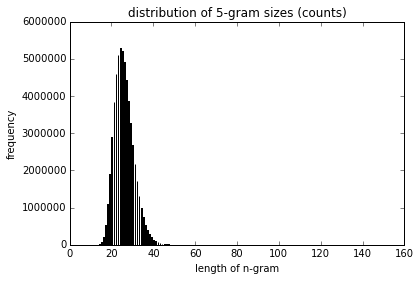

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt

sizes = {}
for line in open('./output/size_distribution.txt').read().strip().split('\n'):
    size, frequency = line.split('\t')
    size = int(size)
    frequency = int(frequency)
    sizes[size] = sizes.get(size, 0) + frequency

fig, ax = plt.subplots()
width = 0.35

distribution = ax.bar(sizes.keys(), sizes.values(), width, color='b')
ax.set_ylabel('frequency')
ax.set_xlabel('length of n-gram')
ax.set_title('distribution of 5-gram sizes (counts) ')

plt.show()

***

<h2><span style="color:dodgerblue;font:12px">HW5.4</span></h2> <br>
<span style="color:firebrick">In this part of the assignment we will focus on developing methods for detecting synonyms, using the Google 5-grams dataset. To accomplish this you must script two main tasks using MRJob:</span>

<span style="color:firebrick;font-size:120%"><b>(1) Build stripes of word co-ocurrence for the top 10,000
most frequently appearing words across the entire set of 5-grams,
and output to a file in your bucket on s3 (bigram analysis, though the words are non-contiguous).<b></span>

<span style="color:CornflowerBlue; font-size: 110%;"><b>Implementation Approach<b></span>

This part of the problem is implemented in two steps

1. Identify top 10,000 most frequently appearing words. This is implementing in the exploratory data analysis in HW5.3
2. Using top 10,000 frequently appearing words, build stripes of word coocurrences across the entire set of 5-grams
    - Pass the unigrams generated from step 1 to the mapper for filtering
    - Reducers would form word cooccurrences if support count of 10,000 is met for the words

In [60]:
import itertools
words = ['a', 'b', 'c']
for word1, word2 in itertools.combinations(words, 2):
    print word1, word2

a b
a c
b c


In [61]:
for i in range(len(words)):
    for j in range(len(words)):
        if words[i] != words[j]:
            print words[i], words[j]

a b
a c
b a
b c
c a
c b


In [48]:
%%writefile FrequentBigrams.py
#!/usr/bin/python
from mrjob.job import MRJob
from mrjob.step import MRStep
import itertools
import sys

class MRFrequentBigrams(MRJob):

    # define MRJob steps
    def steps(self):
        return [
            MRStep(
                mapper_init=self.mapper_init,
                mapper=self.mapper,
                combiner=self.combiner,
                reducer=self.reducer)
        ]

    # load top 10000 frequently appearing words into each memory of each mapper
    def mapper_init(self):
        self.top_unigrams = { k.strip(' "'):v for v, k in (line.split("\t") for line in open('frequent_unigrams_10K.txt').read().strip().split('\n')) }
    
    # emit cooccuring words with count = 1
    def mapper(self, _, line):
        # select only words from the 5-gram that exists in the top 10000
        words = [ word for word in line.lower().split('\t')[0].split() if word in self.top_unigrams.keys() ]
        
        # find bigram co-occurrences
        cooccurences = {}
        for word1, word2 in itertools.combinations(words, 2):
            if word1 in cooccurences.keys():
                cooccurences[word1][word2] = cooccurences[word1].get(word2, 0) + 1
            else:
                cooccurences[word1] = {word2: 1}

        for k, v in cooccurences.iteritems():
            yield (k, v)

    # combine word cooccurrences from the same mapper and emit stripes
    def combiner(self, word, cooccurences):
        stripes = {}

        for stripe in cooccurences:
            for k, v in stripe.iteritems():
                stripes[k] = stripes.get(k, 0) + v

        yield (word, stripes)

    # emit word cooccurrences as stripes
    def reducer(self, word, cooccurences):
        stripes = {}

        for stripe in cooccurences:
            for k, v in stripe.iteritems():
                stripes[k] = stripes.get(k, 0) + v

        yield (word, stripes)

if __name__ == '__main__':
    MRFrequentBigrams.run()

Overwriting FrequentBigrams.py


In [ ]:
from FrequentBigrams import MRFrequentBigrams
import time

start_time = time.time()

# local testing
#!./FrequentBigrams.py -q -r local /home/rt/wrk/w261/hw5/data/googlebooks-eng-all-5gram-20090715-95-filtered.txt --file ./frequent_unigrams_sample.txt --no-strict-protocol 2>/dev/null > word_cooccurences.txt

# on EMR
!./FrequentBigrams.py -q \
    -r emr s3://filtered-5grams \ 
    --output-dir=s3://ucb-mids-mls-rajeshthallam/hw_5_4/bigrams \
    --file s3://ucb-mids-mls-rajeshthallam/hw_5_3/most_frequent_unigrams/frequent_unigrams_10K.txt \
    --no-strict-protocol

end_time = time.time()
print "Time taken to find most frequent bigrams = {:.2f} seconds".format(end_time - start_time)

In [ ]:
!rm -fR output/bigrams
!mkdir -p ./output/bigrams
!aws s3 cp --recursive s3://ucb-mids-mls-rajeshthallam/hw_5_4/bigrams ./output/bigrams
!cat ./output/bigrams/part-* > ./word_cooccurrences.txt
!rm -fR output/bigrams

In [ ]:
!head word_cooccurrences.txt

<span style="color:firebrick;font-size:120%"><b>(2) Using two (symmetric) comparison methods of your choice (e.g., correlations, distances, similarities), pairwise compare all stripes (vectors), and output to a file in your bucket on s3.<b></span>


<span style="color:CornflowerBlue; font-size: 110%;"><b>Implementation Approach<b></span>

For the pairwise comparison between all stripes, pass one instance of word occurrences to all the mappers and another instance as streaming input. This way we can construct symmetric matrix to compare each pair. For the comparison metrics, euclidean distance and cosine similarity is used.

In [58]:
%%writefile SimilarityCalculator.py
#!/usr/bin/python
from mrjob.job import MRJob
from mrjob.step import MRStep
import ast
import math

class MRSimilarityCalculator(MRJob):    
    def mapper(self, _, line):
        # read streaming word occurrence input and evaluate stripes
        stripes = line.strip().split('\t')

        word = stripes[0].strip('"')
        stripe_pairs = ast.literal_eval(stripes[1])

        # read second instance of word cooccurrences broadcasted to the mappers
        for line in open('word_cooccurrences.txt', 'r').read().strip().split('\n'):
            # parse word and stripes
            l_stripes = line.split('\t')

            l_word = l_stripes[0].strip('"')
            l_stripe_pairs = ast.literal_eval(l_stripes[1])

            # avoid symmetric calculations
            # (a, b) = (b, a)
            if word > l_word:
                continue

            # form combined keys to check distance each word 
            combined_words = set(l_stripe_pairs.keys()).union(set(stripe_pairs.keys()))

            # euclidean distance
            euclidean_distance = 0.0
            euclidean_distance = math.sqrt(sum((stripe_pairs.get(k, 0) - l_stripe_pairs.get(k, 0))**2 for k in combined_words))

            # cosine similarity
            cosine_similarity = 0.0
            # norm X
            xx = sum(stripe_pairs.get(k, 0)**2 for k in combined_words)
            # norm Y
            yy = sum(l_stripe_pairs.get(k, 0)**2 for k in combined_words)
            # norm XY
            xy = sum(stripe_pairs.get(k, 0)*l_stripe_pairs.get(k, 0) for k in combined_words)            
            cosine_similarity = xy/math.sqrt(xx*yy)

            # emit word and similarity metrics
            yield ((word, l_word), (euclidean_distance, cosine_similarity))

if __name__ == '__main__':
    MRSimilarityCalculator.run()

Overwriting SimilarityCalculator.py


In [ ]:
from SimilarityCalculator import MRSimilarityCalculator
import time

start_time = time.time()

# local testing
#!./SimilarityCalculator.py ./word_cooccurences.txt -q -r local --file ./word_cooccurences.txt --no-strict-protocol > bigram_similarities.txt

# on EMR
!./SimilarityCalculator.py ./output/word_cooccurrences.txt -q \
    -r emr \
    --file ./output/word_cooccurrences.txt \
    --output-dir=s3://ucb-mids-mls-rajeshthallam/hw_5_4/distance \
    --no-strict-protocol

end_time = time.time()
print "Time taken to find word similarities = {:.2f} seconds".format(end_time - start_time)

In [ ]:
!rm -fR output/distance
!mkdir -p ./output/distance
!aws s3 cp --recursive s3://ucb-mids-mls-rajeshthallam/hw_5_4/distance ./output/distance
!cat ./output/distance/part-* > ./output/bigram_similarities.txt
!rm -fR output/distance

In [ ]:
!head -10 ./output/bigram_similarities.txt

**Alternative approach to calculate pairwise distance with inverted index design pattern**

In [35]:
%%writefile FrequentBigramsv2.py
#!/usr/bin/python
from mrjob.job import MRJob
from mrjob.step import MRStep
import itertools
import sys

class MRFrequentBigrams(MRJob):

    '''
    # define MRJob steps
    def steps(self):
        return [
            MRStep(
                mapper_init=self.mapper_init,
                mapper=self.mapper,
                mapper_final=self.mapper_final,
                #combiner=self.combiner,
                reducer_init=self.reducer_init,
                reducer=self.reducer)
        ]
    '''

    # load top 10000 frequently appearing words into each memory of each mapper
    def mapper_init(self):
        #self.top_unigrams = { k.strip(' "'):v for k, v in (line.split("\t") for line in open('frequent_unigrams_10K.txt').read().strip().split('\n')) }
        self.cooccurrences = {}
        self.top_unigrams = {}
        
        for line in open('frequent_unigrams_10K.txt').read().strip().split('\n'):
            ngram = line.split('\t')
            self.top_unigrams[ngram[0].strip(' "')] = ngram[1]
    
    # emit cooccuring words with count = 1
    def mapper(self, _, line):
        line = line.strip().lower().split('\t')
        # select only words from the 5-gram that exists in the top 10000
        words = [ word for word in line[0].split() if word in self.top_unigrams.keys() ]
        
        # find bigram co-occurrences
        for word1, word2 in itertools.combinations(words, 2):
            if word1 in self.cooccurrences.keys():
                self.cooccurrences[word1][word2] = self.cooccurrences[word1].get(word2, 0) + int(line[1])
            else:
                self.cooccurrences[word1] = {word2: int(line[1])}

    # emit cooccuring words with count = 1
    def mapper_final(self):
        for k, v in self.cooccurrences.iteritems():
            yield (k, v)

    # combine word cooccurrences from the same mapper and emit stripes
    '''
    def combiner(self, word, cooccurrences):
        stripes = {}

        for stripe in cooccurrences:
            for k, v in stripe.iteritems():
                stripes[k] = stripes.get(k, 0) + v

        yield (word, stripes)

    def reducer_init(self):
        #self.top_unigrams = { k.strip(' "'):v for k, v in (line.split("\t") for line in open('frequent_unigrams_10K.txt').read().strip().split('\n')) }
        self.top_unigrams = {}
        
        for line in open('frequent_unigrams_10K.txt').read().strip().split('\n'):
            ngram = line.split('\t')
            self.top_unigrams[ngram[0].strip(' "')] = ngram[1]
    '''

    # emit word cooccurrences as stripes
    def reducer(self, word, cooccurrences):
        stripes = {}

        for stripe in cooccurrences:
            for k, v in stripe.iteritems():
                stripes[k] = stripes.get(k, 0) + v
        
        '''
        out_stripes = []
        for unigram in self.top_unigrams:
            out_stripes.append(stripes.get(unigram, 0))
        '''
            
        yield (word, stripes)

if __name__ == '__main__':
    MRFrequentBigrams.run()

Overwriting FrequentBigramsv2.py


In [30]:
!aws s3 ls s3://ucb-mids-mls-rajeshthallam/hw_5_4/word_cooccurrences --recursive

In [11]:
!head ./output/word_cooccurrences.txt

"he's"	{"a": 1, "gone": 1, "end": 1, "for": 1, "be": 1, "of": 1, "taking": 1, "been": 2, "keep": 1, "looking": 1, "to": 2, "enough": 1, "going": 1, "supposed": 1, "twenty": 1, "me": 2, "the": 1, "minutes": 1, "guy": 1, "at": 1, "nice": 1}
"head"	{"and": 2, "again": 1, "like": 1, "to": 1, "of": 7, "charles": 1, "turned": 1, "been": 1, "down": 1, "chamber": 1, "pure": 1, "were": 1, "the": 3, "wool": 1, "had": 1}
"heads"	{"of": 1}
"health"	{"and": 2, "commissioner": 1, "statistics": 1, "england": 1, "service": 1, "for": 2, "ministry": 1, "of": 1, "is": 2, "rights": 1, "only": 1, "hygiene": 1, "human": 1, "in": 1, "not": 1, "international": 1, "the": 2, "agriculture": 1, "responsible": 1}
"hear"	{"was": 1, "remark": 1, "her": 1, "what": 1, "this": 1, "of": 1, "some": 1, "dog": 1, "one": 1, "tell": 1, "in": 1, "the": 4, "story": 1, "footsteps": 1, "your": 1}
"heard"	{"people": 1, "sigh": 1, "coming": 1, "it": 3, "one": 1, "as": 1, "in": 1, "my": 1, "sounds": 1, "captain": 1, "any": 1, "stor

In [31]:
!aws s3 rm s3://ucb-mids-mls-rajeshthallam/hw_5_4/word_cooccurrences --recursive

In [38]:
from FrequentBigramsv2 import MRFrequentBigrams
import time

start_time = time.time()

# local testing
#!./FrequentBigramsv2.py -q -r local /home/rt/wrk/w261/hw5/data/googlebooks-eng-all-5gram-20090715-154-filtered.txt --file ./output/frequent_unigrams_10K.txt --no-strict-protocol > ./output/word_cooccurrences.txt
#!./FrequentBigramsv2.py -r local /home/rt/wrk/w261/hw5/sample.txt --file ./output/frequent_unigrams_10K.txt --no-strict-protocol > ./output/word_cooccurrences.txt

# on EMR
!./FrequentBigramsv2.py \
    -r emr s3://filtered-5grams \
    --file ./output/frequent_unigrams_10K.txt \
    --output-dir=s3://ucb-mids-mls-rajeshthallam/hw_5_4/word_cooccurrences \
    --no-output \
    --no-strict-protocol

end_time = time.time()
print "Time taken to find most frequent bigrams = {:.2f} seconds".format(end_time - start_time)

using configs in /home/rt/.mrjob.conf
using existing scratch bucket mrjob-d6a3c2a2131f0b94
using s3://mrjob-d6a3c2a2131f0b94/tmp/ as our scratch dir on S3
creating tmp directory /tmp/FrequentBigramsv2.rt.20151013.014354.494791
writing master bootstrap script to /tmp/FrequentBigramsv2.rt.20151013.014354.494791/b.py
Copying non-input files into s3://mrjob-d6a3c2a2131f0b94/tmp/FrequentBigramsv2.rt.20151013.014354.494791/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Job flow created with ID: j-32QE2ILC9DSG
Created new job flow j-32QE2ILC9DSG
Job launched 32.0s ago, status STARTING
Job launched 63.8s ago, status STARTING
Job launched 95.9s ago, status STARTING
Job launched 127.8s ago, status STARTING: Configuring cluster software
Job launched 159.6s ago, status BOOTSTRAPPING: Running bootstrap actions
Job launched 192.0s ago, status BOOTSTRAPPING: Running bootstrap actions
Job launched 224.0s ago, status RUNNING: Running step
Job launched 256.1s ago, st

In [39]:
!rm -fR output/bigrams
!mkdir -p ./output/bigrams
!aws s3 cp --recursive s3://ucb-mids-mls-rajeshthallam/hw_5_4/word_cooccurrences ./output/bigrams
!cat ./output/bigrams/part-* > ./output/word_cooccurrences.txt
#!rm -fR output/bigrams

download: s3://ucb-mids-mls-rajeshthallam/hw_5_4/word_cooccurrences/_SUCCESS to output/bigrams/_SUCCESS
download: s3://ucb-mids-mls-rajeshthallam/hw_5_4/word_cooccurrences/part-00003 to output/bigrams/part-00003
download: s3://ucb-mids-mls-rajeshthallam/hw_5_4/word_cooccurrences/part-00001 to output/bigrams/part-00001
download: s3://ucb-mids-mls-rajeshthallam/hw_5_4/word_cooccurrences/part-00000 to output/bigrams/part-00000
download: s3://ucb-mids-mls-rajeshthallam/hw_5_4/word_cooccurrences/part-00002 to output/bigrams/part-00002
download: s3://ucb-mids-mls-rajeshthallam/hw_5_4/word_cooccurrences/part-00005 to output/bigrams/part-00005
download: s3://ucb-mids-mls-rajeshthallam/hw_5_4/word_cooccurrences/part-00008 to output/bigrams/part-00008
download: s3://ucb-mids-mls-rajeshthallam/hw_5_4/word_cooccurrences/part-00004 to output/bigrams/part-00004
download: s3://ucb-mids-mls-rajeshthallam/hw_5_4/word_cooccurrences/part-00007 to output/bigrams/part-00007
download: s3://ucb-mids-mls-raje

In [ ]:
!tail ./output/word_cooccurrences.txt

In [42]:
%%writefile DistCalcInvIdx.py
#!/usr/bin/python
from mrjob.job import MRJob
from mrjob.step import MRStep
import ast
import sys
import math

class MRDistCalcInvIdx(MRJob):
    # define MRJob steps
    def steps(self):
        return [
            MRStep(
                mapper=self.mapper_idx,
                reducer=self.reducer_idx),
            MRStep(
                mapper_init=self.mapper_distance_init,
                mapper=self.mapper_distance,
                reducer=self.reducer_distance)
        ]

    # stage1: indexing
    def mapper_idx(self, _, line):
        line = line.strip().split('\t')
        
        word1 = line[0].strip('"')
        stripe = ast.literal_eval(line[1])
        
        for word2, count in stripe.iteritems():
            yield word2, (word1, int(count))

    def reducer_idx(self, word2, word1_count):
        word1_counts = [w for w in word1_count]
        yield word2, word1_counts

    # stage2: pairwise similarity using euclidean and cosine
    def mapper_distance_init(self):
        self.columns = {}
        self.top_unigrams = {}
        
        for line in open('frequent_unigrams_10K.txt').read().strip().split('\n'):
            ngram = line.split('\t')
            self.top_unigrams[ngram[0].strip(' "')] = ngram[1]
        
    def mapper_distance(self, word2, word1_counts):
        postings = []
        words = { x[0].strip('"'):int(x[1]) for x in word1_counts }

        for key in self.top_unigrams:
            postings.append((key, words.get(key, 0)))
        
        postings = sorted(postings)
        l = len(postings)

        for i in xrange(l):
            for j in xrange(l):
                if j > i:
                    x = postings[i][1]
                    y = postings[j][1]
                    yield (postings[i][0], postings[j][0]), ((x-y)**2, x*x, y*y, x*y)
        
    def reducer_distance(self, words, distance_measures):
        d = distance_measures

        # euclidean
        euclidean = math.sqrt(sum([l[0] for l in d]))
        
        # cosine similarity
        xx = sum([l[1] for l in d])
        yy = sum([l[2] for l in d])
        xy = sum([l[4] for l in d])
        if xx == 0 or yy == 0:
            cosine = 0
        else:
            cosine = xy/math.sqrt(xx*yy)
        
        if cosine > 0.0:
            yield (words), (euclidean, cosine)                 

if __name__ == '__main__':
    MRDistCalcInvIdx.run()

Overwriting DistCalcInvIdx.py


In [43]:
from DistCalcInvIdx import MRDistCalcInvIdx
import time

start_time = time.time()

# local testing
#!./DistCalcInvIdx.py ./output/word_cooccurrences.txt -r local --file ./output/frequent_unigrams_10K.txt --no-strict-protocol > ./output/distances.txt

# on EMR
!./DistCalcInvIdx.py ./output/word_cooccurrences.txt \
    -r emr \
    --file ./output/word_cooccurrences.txt \
    --output-dir=s3://ucb-mids-mls-rajeshthallam/hw_5_4/DistInvDx \
    --no-strict-protocol

end_time = time.time()
print "Time taken to calculate distances = {:.2f} seconds".format(end_time - start_time)

using configs in /home/rt/.mrjob.conf
using existing scratch bucket mrjob-d6a3c2a2131f0b94
using s3://mrjob-d6a3c2a2131f0b94/tmp/ as our scratch dir on S3
creating tmp directory /tmp/DistCalcInvIdx.rt.20151013.145035.038792
writing master bootstrap script to /tmp/DistCalcInvIdx.rt.20151013.145035.038792/b.py
Copying non-input files into s3://mrjob-d6a3c2a2131f0b94/tmp/DistCalcInvIdx.rt.20151013.145035.038792/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Job flow created with ID: j-U310CENQ5J92
Created new job flow j-U310CENQ5J92
Job launched 33.4s ago, status STARTING
Job launched 65.3s ago, status STARTING
Job launched 97.3s ago, status STARTING
Job launched 129.5s ago, status STARTING: Configuring cluster software
Job launched 161.6s ago, status STARTING: Configuring cluster software
Job launched 193.6s ago, status BOOTSTRAPPING: Running bootstrap actions
Job launched 226.9s ago, status BOOTSTRAPPING: Running bootstrap actions
Job launched 258.7s

***

<h3><span style="color:dodgerblue;font:12px">HW5.5</span></h3> 
<span style="color:firebrick"> In this part of the assignment you will evaluate the success of you synonym detector.
Take the top 1,000 closest/most similar/correlative pairs of words as determined by your measure in (2), and use the synonyms function in the accompanying python [code](nltk_synonyms.py)

For each (word1,word2) pair, check to see if word1 is in the list, synonyms(word2), and vice-versa. If one of the two is a synonym of the other, then consider this pair a 'hit', and then report the precision, recall, and F1 measure  of your detector across your 1,000 best guesses. Report the macro averages of these measures.</span>

<span style="color:CornflowerBlue;font-size:110%;"><b>Implementation Approach</b></span><br>

In [ ]:
!awk -F"\t" '{split($2, a, " "); print $1, a[1]}' ./output/bigram_similarities.txt | sort -k1nr | head-1000 > ./output/euclidean_dist_top_1K.txt
!awk -F"\t" '{split($2, a, " "); print $1, a[2]}' ./output/bigram_similarities.txt | sort -k1nr | head-1000 > ./output/cosine_sim_top_1K.txt

In [ ]:
%%writefile SynonymCheck.py
import nltk
from nltk.corpus import wordnet as wn

import sys
import ast

#print all the synset element of an element
def synonyms(string):
    syndict = {}
    for i,j in enumerate(wn.synsets(string)):
        syns = j.lemma_names()
        for syn in syns:
            syndict.setdefault(syn,1)
    return syndict.keys()

<span style="color:firebrick">** -- END OF ASSIGNMENT 5 -- **</span>